# MINST Digit Generation using GAN
Here we try to generate 'fake' digits between 0 and 9 as if they belong to the MINST dataset using a simple Generative Adversarial Network (GAN)

In [1]:
import math
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## Load Data and Explore

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.MNIST(root='./data', 
                          train=True,
                          download=True,
                          transform=transform)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 28.7MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 828kB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 6.99MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.73MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
print(train_ds.data.shape)
print(train_ds.targets.shape)
print(train_ds.classes)
print(train_ds.data[0])
print(train_ds.targets[0])
print(train_ds.data[0].max())
print(train_ds.data[0].min())
print(train_ds.data[0].float().mean())
print(train_ds.data[0].float().std())

torch.Size([60000, 28, 28])
torch.Size([60000])
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   

In [5]:
# Build dataloader
dl = DataLoader(dataset=train_ds,
                shuffle=True,
                batch_size=64)

In [6]:
# Examine a sample batch from the dataloader
image_batch = next(iter(dl))
print(len(image_batch), type(image_batch))
print(image_batch[0].shape)
print(image_batch[1].shape)

2 <class 'list'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


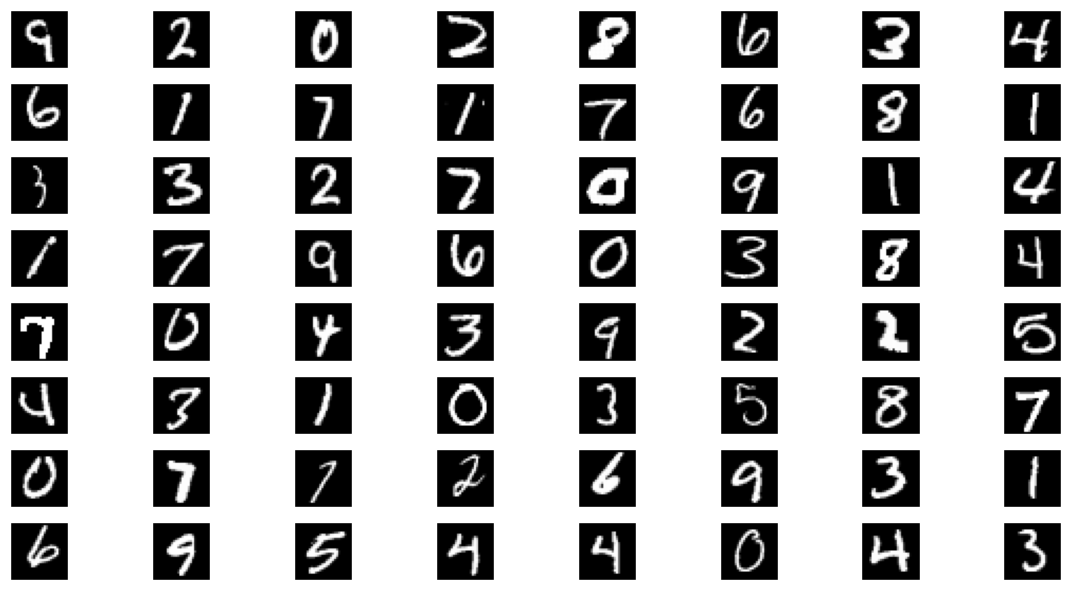

In [7]:
## ----------------------------------------------------------------------------
## Visualise a sample batch
## ----------------------------------------------------------------------------

def display_images(images, n_cols=4, figsize=(12, 6)):
    """
    Utility function to display a collection of images in a grid
    
    Parameters
    ----------
    images: Tensor
            tensor of shape (batch_size, channel, height, width)
            containing images to be displayed
    n_cols: int
            number of columns in the grid
            
    Returns
    -------
    None
    """
    plt.style.use('ggplot')
    n_images = len(images)
    n_rows = math.ceil(n_images / n_cols)
    plt.figure(figsize=figsize)
    for idx in range(n_images):
        ax = plt.subplot(n_rows, n_cols, idx+1)
        image = images[idx]
        # make dims H x W x C
        image = image.permute(1, 2, 0)
        cmap = 'gray' if image.shape[2] == 1 else plt.cm.viridis
        ax.imshow(image, cmap=cmap)
        ax.set_xticks([])
        ax.set_yticks([])        
    plt.tight_layout()
    plt.show()

display_images(images=image_batch[0], n_cols=8)

## Define the Network

### Discriminator Network

In [8]:
class Discriminator(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Discriminator will down-sample the input producing a binary output
        self.fc1 = nn.Linear(in_features=in_features, out_features=128)
        self.leaky_relu1 = nn.LeakyReLU(negative_slope=0.2)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.leaky_relu2 = nn.LeakyReLU(negative_slope=0.2)        
        self.fc3 = nn.Linear(in_features=64, out_features=32)
        self.leaky_relu3 = nn.LeakyReLU(negative_slope=0.2)        
        self.fc4 = nn.Linear(in_features=32, out_features=out_features)
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        # Rehape passed image batch
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        # Feed forward
        x = self.fc1(x)
        x = self.leaky_relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.leaky_relu2(x)
        x = self.dropout(x)                        
        x = self.fc3(x)
        x = self.leaky_relu3(x)        
        x = self.dropout(x)
        logit_out = self.fc4(x)
        
        return logit_out

### Generator Network

In [9]:
class Generator(nn.Module):
    def __init__(self, in_features, out_features):
        super(Generator, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Generator will up-sample the input producing input of size
        # suitable for feeding into discriminator
        self.fc1 = nn.Linear(in_features=in_features, out_features=32)
        self.relu1 = nn.LeakyReLU(negative_slope=0.2)
        self.fc2 = nn.Linear(in_features=32, out_features=64)
        self.relu2 = nn.LeakyReLU(negative_slope=0.2)        
        self.fc3 = nn.Linear(in_features=64, out_features=128)
        self.relu3 = nn.LeakyReLU(negative_slope=0.2)        
        self.fc4 = nn.Linear(in_features=128, out_features=out_features)
        self.dropout = nn.Dropout(0.3)
        self.tanh = nn.Tanh()
        
        
    def forward(self, x):
        # Feed forward
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu2(x)        
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu3(x)        
        x = self.dropout(x)
        x = self.fc4(x)
        tanh_out = self.tanh(x)
        
        return tanh_out

## Define Losses

In [10]:
def real_loss(predicted_outputs, loss_fn, device):
    """
    Function for calculating loss when samples are drawn from real dataset
    
    Parameters
    ----------
    predicted_outputs: Tensor
                       predicted logits
            
    Returns
    -------
    real_loss: int
    """
    batch_size = predicted_outputs.shape[0]
    # Targets are set to 1 here because we expect prediction to be 
    # 1 (or near 1) since samples are drawn from real dataset
    targets = torch.ones(batch_size).to(device)
    real_loss = loss_fn(predicted_outputs.squeeze(), targets)
    
    return real_loss


def fake_loss(predicted_outputs, loss_fn, device):
    """
    Function for calculating loss when samples are generated fake samples
    
    Parameters
    ----------
    predicted_outputs: Tensor
                       predicted logits
            
    Returns
    -------
    fake_loss: int
    """
    batch_size = predicted_outputs.shape[0]
    # Targets are set to 0 here because we expect prediction to be 
    # 0 (or near 0) since samples are generated fake samples
    targets = torch.zeros(batch_size).to(device)
    fake_loss = loss_fn(predicted_outputs.squeeze(), targets)
    
    return fake_loss 

## Train the network
Discriminator and Generator will be trained together we need separate optimizer for them

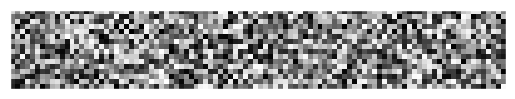

In [11]:
#Sample generation of latent vector
z_size = 100
z = np.random.uniform(-1, 1, size=(16, z_size))
plt.imshow(z, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

In [14]:
# Training loop function
from tqdm import tqdm

def train_minst_gan(d, g, d_optim, g_optim, loss_fn, dl, n_epochs, device, verbose=False):
    print(f'Training on [{device}]...')
    
    # Generate a batch (say 16) of latent image vector (z) of fixed size 
    # (say 100 pix) to be as input to the Generator after each epoch of 
    # training to generate a fake image. We'll visualise these fake images
    # to get a sense how generator improves as training progresses
    z_size = 100
    fixed_z = np.random.uniform(-1, 1, size=(16, z_size))
    fixed_z = torch.from_numpy(fixed_z).float().to(device)          
    fixed_samples = []
    d_losses = []
    g_losses = []
    
    
    # Move discriminator and generator to available device
    d = d.to(device)
    g = g.to(device)
    
    for epoch in range(n_epochs):
        print(f'Epoch [{epoch+1}/{n_epochs}]:')
        # Switch the training mode on
        d.train()
        g.train()
        d_running_batch_loss = 0
        g_running_batch_loss = 0
        for curr_batch, (real_images, _) in tqdm(enumerate(dl)):
            # Move input batch to available device
            real_images = real_images.to(device)
            
            ## ----------------------------------------------------------------
            ## Train discriminator using real and then fake MNIST images,  
            ## then compute the total-loss and back-propogate the total-loss
            ## ----------------------------------------------------------------
            
            # Reset gradients
            d_optim.zero_grad()
            
            # Real MNIST images
            # Convert real_images value range of 0 to 1 to -1 to 1
            # this is required because latter discriminator would be required 
            # to consume generator's 'tanh' output which is of range -1 to 1
            real_images = (real_images * 2) - 1  
            d_real_logits_out = d(real_images)
            d_real_loss = real_loss(d_real_logits_out, loss_fn, device)
            #d_real_loss = real_loss(d_real_logits_out, smooth=True)
            
            # Fake images
            with torch.no_grad():
                # Generate a batch of random latent vectors 
                z = np.random.uniform(-1, 1, size=(dl.batch_size, z_size))
                z = torch.from_numpy(z).float().to(device)
                # Generate batch of fake images
                fake_images = g(z) 
            # feed fake-images to discriminator and compute the 
            # fake_loss (i.e. target label = 0)
            d_fake_logits_out = d(fake_images)
            d_fake_loss = fake_loss(d_fake_logits_out, loss_fn, device)
            #d_fake_loss = fake_loss(d_fake_logits_out)
            # Compute total discriminator loss
            d_loss = d_real_loss + d_fake_loss
            # Backpropogate through discriminator
            d_loss.backward()
            d_optim.step()
            # Save discriminator batch loss
            d_running_batch_loss += d_loss
            
            ## ----------------------------------------------------------------
            ## Train generator, compute the generator loss which is a measure
            ## of how successful the generator is in tricking the discriminator 
            ## and finally back-propogate generator loss
            ## ----------------------------------------------------------------

            # Reset gradients
            g_optim.zero_grad()
            
            # Generate a batch of random latent vectors
            #z = torch.rand(size=(dl.batch_size, z_size)).to(device)
            z = np.random.uniform(-1, 1, size=(dl.batch_size, z_size))
            z = torch.from_numpy(z).float().to(device)       
            # Generate a batch of fake images, feed them to discriminator
            # and compute the generator loss as real_loss 
            # (i.e. target label = 1)
            fake_images = g(z) 
            g_logits_out = d(fake_images)
            g_loss = real_loss(g_logits_out, loss_fn, device)
            #g_loss = real_loss(g_logits_out)
            # Backpropogate thorugh generator
            g_loss.backward()
            g_optim.step()
            # Save discriminator batch loss
            g_running_batch_loss += g_loss
            
            # Display training stats for every 200 batches 
            if curr_batch % 400 == 0 and verbose:
                print(f'\tBatch [{curr_batch:>4}/{len(dl):>4}] - d_batch_loss: {d_loss.item():.6f}\tg_batch_loss: {g_loss.item():.6f}')
            
        # Compute epoch losses as total_batch_loss/number_of_batches
        d_epoch_loss = d_running_batch_loss.item()/len(dl)
        g_epoch_loss = g_running_batch_loss.item()/len(dl)
        d_losses.append(d_epoch_loss)
        g_losses.append(g_epoch_loss)
        
        # Display training stats for every 200 batches 
        print(f'epoch_d_loss: {d_epoch_loss:.6f} \tepoch_g_loss: {g_epoch_loss:.6f}')
        
        # Generate fake images from fixed latent vector using the trained 
        # generator so far and save images for latter viewing
        g.eval()
        fixed_samples.append(g(fixed_z).detach().cpu())
        
    # Finally write generated fake images from fixed latent vector to disk
    with open('fixed_samples.pkl', 'wb') as f:
        pkl.dump(fixed_samples, f)
     
    return d_losses, g_losses

In [ ]:
##
## Prepare and start training
##

# Instantiate Discriminator and Generator
d = Discriminator(in_features=784, out_features=1)
g = Generator(in_features=100, out_features=784)
#g = Generator(100, 32, 784)
print(d)
print()
print(g)

# Instantiate optimizers
d_optim = optim.Adam(d.parameters(), lr=0.002)
g_optim = optim.Adam(g.parameters(), lr=0.002)

# Instantiate the loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Train
n_epochs = 150
d_losses, g_losses = train_minst_gan(d, g, d_optim, g_optim, 
                                     loss_fn, dl, n_epochs, device,
                                     verbose=False)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (leaky_relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (tanh): Tanh()
)
Training on [cuda]...
Epoch [1/150]:


938it [00:10, 85.45it/s]


epoch_d_loss: 1.050755 	epoch_g_loss: 2.892571
Epoch [2/150]:


938it [00:10, 85.84it/s]


epoch_d_loss: 1.231022 	epoch_g_loss: 1.199501
Epoch [3/150]:


938it [00:11, 84.88it/s]


epoch_d_loss: 0.905948 	epoch_g_loss: 1.683617
Epoch [4/150]:


938it [00:10, 85.28it/s]


epoch_d_loss: 0.897105 	epoch_g_loss: 1.635988
Epoch [5/150]:


938it [00:10, 85.71it/s]


epoch_d_loss: 1.059666 	epoch_g_loss: 1.423518
Epoch [6/150]:


938it [00:11, 84.52it/s]


epoch_d_loss: 1.049231 	epoch_g_loss: 1.380175
Epoch [7/150]:


938it [00:10, 85.41it/s]


epoch_d_loss: 1.119666 	epoch_g_loss: 1.214132
Epoch [8/150]:


938it [00:10, 85.41it/s]


epoch_d_loss: 1.140901 	epoch_g_loss: 1.130580
Epoch [9/150]:


938it [00:10, 86.33it/s]


epoch_d_loss: 1.191577 	epoch_g_loss: 1.069216
Epoch [10/150]:


938it [00:10, 86.53it/s]


epoch_d_loss: 1.194935 	epoch_g_loss: 1.054354
Epoch [11/150]:


938it [00:11, 84.33it/s]


epoch_d_loss: 1.232477 	epoch_g_loss: 0.996093
Epoch [12/150]:


938it [00:10, 85.86it/s]


epoch_d_loss: 1.215718 	epoch_g_loss: 1.014459
Epoch [13/150]:


938it [00:10, 86.58it/s]


epoch_d_loss: 1.207595 	epoch_g_loss: 1.031369
Epoch [14/150]:


938it [00:11, 84.88it/s]


epoch_d_loss: 1.224823 	epoch_g_loss: 0.999516
Epoch [15/150]:


938it [00:10, 86.07it/s]


epoch_d_loss: 1.213328 	epoch_g_loss: 1.030184
Epoch [16/150]:


938it [00:10, 85.72it/s]


epoch_d_loss: 1.216001 	epoch_g_loss: 1.027294
Epoch [17/150]:


938it [00:11, 85.20it/s]


epoch_d_loss: 1.221965 	epoch_g_loss: 1.007193
Epoch [18/150]:


938it [00:10, 85.70it/s]


epoch_d_loss: 1.215737 	epoch_g_loss: 1.026832
Epoch [19/150]:


938it [00:10, 85.33it/s]


epoch_d_loss: 1.210511 	epoch_g_loss: 1.040240
Epoch [20/150]:


938it [00:10, 85.57it/s]


epoch_d_loss: 1.219166 	epoch_g_loss: 1.015152
Epoch [21/150]:


938it [00:10, 86.63it/s]


epoch_d_loss: 1.224160 	epoch_g_loss: 1.006939
Epoch [22/150]:


938it [00:10, 86.48it/s]


epoch_d_loss: 1.217262 	epoch_g_loss: 1.008880
Epoch [23/150]:


938it [00:10, 85.32it/s]


epoch_d_loss: 1.238681 	epoch_g_loss: 0.985673
Epoch [24/150]:


938it [00:10, 86.12it/s]


epoch_d_loss: 1.229691 	epoch_g_loss: 0.994198
Epoch [25/150]:


938it [00:10, 85.98it/s]


epoch_d_loss: 1.235820 	epoch_g_loss: 0.981289
Epoch [26/150]:


938it [00:11, 85.23it/s]


epoch_d_loss: 1.229753 	epoch_g_loss: 1.016479
Epoch [27/150]:


938it [00:10, 86.06it/s]


epoch_d_loss: 1.231626 	epoch_g_loss: 0.990508
Epoch [28/150]:


938it [00:10, 85.91it/s]


epoch_d_loss: 1.226511 	epoch_g_loss: 0.993206
Epoch [29/150]:


938it [00:11, 84.96it/s]


epoch_d_loss: 1.236664 	epoch_g_loss: 0.975977
Epoch [30/150]:


938it [00:10, 85.84it/s]


epoch_d_loss: 1.237273 	epoch_g_loss: 1.001928
Epoch [31/150]:


938it [00:10, 85.77it/s]


epoch_d_loss: 1.230125 	epoch_g_loss: 0.995616
Epoch [32/150]:


938it [00:10, 86.00it/s]


epoch_d_loss: 1.232515 	epoch_g_loss: 0.996966
Epoch [33/150]:


938it [00:10, 85.85it/s]


epoch_d_loss: 1.230922 	epoch_g_loss: 1.000474
Epoch [34/150]:


938it [00:10, 85.28it/s]


epoch_d_loss: 1.234130 	epoch_g_loss: 0.976904
Epoch [35/150]:


938it [00:10, 86.18it/s]


epoch_d_loss: 1.227687 	epoch_g_loss: 1.011244
Epoch [36/150]:


938it [00:10, 86.05it/s]


epoch_d_loss: 1.221904 	epoch_g_loss: 1.011335
Epoch [37/150]:


938it [00:10, 85.75it/s]


epoch_d_loss: 1.222915 	epoch_g_loss: 0.991990
Epoch [38/150]:


938it [00:10, 86.22it/s]


epoch_d_loss: 1.220006 	epoch_g_loss: 1.009049
Epoch [39/150]:


938it [00:10, 85.60it/s]


epoch_d_loss: 1.227580 	epoch_g_loss: 0.979162
Epoch [40/150]:


938it [00:10, 85.55it/s]


epoch_d_loss: 1.223968 	epoch_g_loss: 1.007232
Epoch [41/150]:


938it [00:10, 86.24it/s]


epoch_d_loss: 1.238601 	epoch_g_loss: 0.963835
Epoch [42/150]:


938it [00:10, 86.50it/s]


epoch_d_loss: 1.236884 	epoch_g_loss: 0.995744
Epoch [43/150]:


938it [00:10, 86.21it/s]


epoch_d_loss: 1.235972 	epoch_g_loss: 0.976333
Epoch [44/150]:


938it [00:10, 85.78it/s]


epoch_d_loss: 1.226050 	epoch_g_loss: 0.993992
Epoch [45/150]:


938it [00:10, 86.05it/s]


epoch_d_loss: 1.228033 	epoch_g_loss: 1.004473
Epoch [46/150]:


938it [00:11, 85.21it/s]


epoch_d_loss: 1.226741 	epoch_g_loss: 1.005803
Epoch [47/150]:


938it [00:10, 86.02it/s]


epoch_d_loss: 1.223766 	epoch_g_loss: 1.000181
Epoch [48/150]:


938it [00:10, 86.45it/s]


epoch_d_loss: 1.234630 	epoch_g_loss: 0.995364
Epoch [49/150]:


938it [00:10, 85.76it/s]


epoch_d_loss: 1.226411 	epoch_g_loss: 1.000474
Epoch [50/150]:


938it [00:10, 86.04it/s]


epoch_d_loss: 1.217287 	epoch_g_loss: 1.006571
Epoch [51/150]:


938it [00:10, 86.83it/s]


epoch_d_loss: 1.225700 	epoch_g_loss: 0.986105
Epoch [52/150]:


938it [00:10, 85.75it/s]


epoch_d_loss: 1.231755 	epoch_g_loss: 0.972995
Epoch [53/150]:


938it [00:10, 86.19it/s]


epoch_d_loss: 1.241137 	epoch_g_loss: 1.003318
Epoch [54/150]:


938it [00:10, 86.95it/s]


epoch_d_loss: 1.215756 	epoch_g_loss: 1.011574
Epoch [55/150]:


938it [00:10, 85.82it/s]


epoch_d_loss: 1.215389 	epoch_g_loss: 1.009330
Epoch [56/150]:


938it [00:10, 86.31it/s]


epoch_d_loss: 1.219894 	epoch_g_loss: 1.021380
Epoch [57/150]:


938it [00:10, 85.57it/s]


epoch_d_loss: 1.216190 	epoch_g_loss: 1.015047
Epoch [58/150]:


938it [00:10, 85.95it/s]


epoch_d_loss: 1.224237 	epoch_g_loss: 1.000614
Epoch [59/150]:


938it [00:10, 86.21it/s]


epoch_d_loss: 1.230539 	epoch_g_loss: 0.987698
Epoch [60/150]:


938it [00:11, 84.92it/s]


epoch_d_loss: 1.237710 	epoch_g_loss: 0.972882
Epoch [61/150]:


938it [00:10, 86.79it/s]


epoch_d_loss: 1.226720 	epoch_g_loss: 1.011771
Epoch [62/150]:


938it [00:10, 86.19it/s]


epoch_d_loss: 1.217260 	epoch_g_loss: 1.019272
Epoch [63/150]:


938it [00:11, 84.90it/s]


epoch_d_loss: 1.213833 	epoch_g_loss: 1.020749
Epoch [64/150]:


938it [00:10, 86.50it/s]


epoch_d_loss: 1.224862 	epoch_g_loss: 1.016451
Epoch [65/150]:


938it [00:10, 86.03it/s]


epoch_d_loss: 1.214134 	epoch_g_loss: 1.011499
Epoch [66/150]:


938it [00:11, 84.79it/s]


epoch_d_loss: 1.221888 	epoch_g_loss: 1.009328
Epoch [67/150]:


938it [00:10, 86.15it/s]


epoch_d_loss: 1.220412 	epoch_g_loss: 1.008850
Epoch [68/150]:


938it [00:10, 86.29it/s]


epoch_d_loss: 1.214205 	epoch_g_loss: 1.005007
Epoch [69/150]:


938it [00:11, 84.56it/s]


epoch_d_loss: 1.220136 	epoch_g_loss: 1.026274
Epoch [70/150]:


938it [00:11, 85.27it/s]


epoch_d_loss: 1.221784 	epoch_g_loss: 0.998627
Epoch [71/150]:


938it [00:10, 85.82it/s]


epoch_d_loss: 1.218888 	epoch_g_loss: 1.017942
Epoch [72/150]:


938it [00:11, 84.53it/s]


epoch_d_loss: 1.222559 	epoch_g_loss: 0.990208
Epoch [73/150]:


938it [00:10, 86.41it/s]


epoch_d_loss: 1.228886 	epoch_g_loss: 0.986119
Epoch [74/150]:


938it [00:10, 86.02it/s]


epoch_d_loss: 1.225793 	epoch_g_loss: 1.009288
Epoch [75/150]:


938it [00:11, 84.37it/s]


epoch_d_loss: 1.216470 	epoch_g_loss: 1.015049
Epoch [76/150]:


938it [00:10, 85.63it/s]


epoch_d_loss: 1.221578 	epoch_g_loss: 1.009474
Epoch [77/150]:


938it [00:10, 86.09it/s]


epoch_d_loss: 1.208174 	epoch_g_loss: 1.032945
Epoch [78/150]:


938it [00:11, 84.80it/s]


epoch_d_loss: 1.214468 	epoch_g_loss: 1.023019
Epoch [79/150]:


938it [00:10, 86.78it/s]


epoch_d_loss: 1.215139 	epoch_g_loss: 1.020075
Epoch [80/150]:


938it [00:11, 84.92it/s]


epoch_d_loss: 1.214323 	epoch_g_loss: 1.015308
Epoch [81/150]:


938it [00:10, 86.95it/s]


epoch_d_loss: 1.207403 	epoch_g_loss: 1.036410
Epoch [82/150]:


938it [00:10, 86.53it/s]


epoch_d_loss: 1.210629 	epoch_g_loss: 1.012656
Epoch [83/150]:


938it [00:11, 85.03it/s]


epoch_d_loss: 1.214400 	epoch_g_loss: 1.025439
Epoch [84/150]:


938it [00:10, 86.99it/s]


epoch_d_loss: 1.218620 	epoch_g_loss: 1.012310
Epoch [85/150]:


938it [00:10, 86.78it/s]


epoch_d_loss: 1.211728 	epoch_g_loss: 1.021380
Epoch [86/150]:


938it [00:10, 85.30it/s]


epoch_d_loss: 1.207054 	epoch_g_loss: 1.062171
Epoch [87/150]:


938it [00:10, 86.33it/s]


epoch_d_loss: 1.210105 	epoch_g_loss: 1.019621
Epoch [88/150]:


938it [00:10, 85.97it/s]


epoch_d_loss: 1.217069 	epoch_g_loss: 1.011114
Epoch [89/150]:


938it [00:10, 85.68it/s]


epoch_d_loss: 1.213556 	epoch_g_loss: 1.026221
Epoch [90/150]:


938it [00:10, 86.70it/s]


epoch_d_loss: 1.206243 	epoch_g_loss: 1.034718
Epoch [91/150]:


938it [00:10, 85.79it/s]


epoch_d_loss: 1.216836 	epoch_g_loss: 1.016446
Epoch [92/150]:


938it [00:10, 85.38it/s]


epoch_d_loss: 1.203575 	epoch_g_loss: 1.045447
Epoch [93/150]:


938it [00:10, 86.52it/s]


epoch_d_loss: 1.204714 	epoch_g_loss: 1.036641
Epoch [94/150]:


938it [00:10, 86.13it/s]


epoch_d_loss: 1.208440 	epoch_g_loss: 1.021773
Epoch [95/150]:


938it [00:11, 85.24it/s]


epoch_d_loss: 1.213544 	epoch_g_loss: 1.022161
Epoch [96/150]:


938it [00:10, 85.98it/s]


epoch_d_loss: 1.209888 	epoch_g_loss: 1.026191
Epoch [97/150]:


938it [00:10, 86.20it/s]


epoch_d_loss: 1.209517 	epoch_g_loss: 1.027482
Epoch [98/150]:


938it [00:10, 86.00it/s]


epoch_d_loss: 1.211404 	epoch_g_loss: 1.017778
Epoch [99/150]:


938it [00:10, 86.26it/s]


epoch_d_loss: 1.205318 	epoch_g_loss: 1.032717
Epoch [100/150]:


938it [00:10, 86.01it/s]


epoch_d_loss: 1.204911 	epoch_g_loss: 1.035583
Epoch [101/150]:


938it [00:11, 85.18it/s]


epoch_d_loss: 1.207362 	epoch_g_loss: 1.031953
Epoch [102/150]:


938it [00:10, 86.26it/s]


epoch_d_loss: 1.196822 	epoch_g_loss: 1.055863
Epoch [103/150]:


938it [00:11, 84.88it/s]


epoch_d_loss: 1.202947 	epoch_g_loss: 1.037725
Epoch [104/150]:


938it [00:11, 84.39it/s]


epoch_d_loss: 1.207472 	epoch_g_loss: 1.040240
Epoch [105/150]:


938it [00:10, 86.19it/s]


epoch_d_loss: 1.204527 	epoch_g_loss: 1.043196
Epoch [106/150]:


938it [00:10, 85.44it/s]


epoch_d_loss: 1.195955 	epoch_g_loss: 1.047993
Epoch [107/150]:


938it [00:10, 86.52it/s]


epoch_d_loss: 1.199080 	epoch_g_loss: 1.052058
Epoch [108/150]:


938it [00:10, 85.92it/s]


epoch_d_loss: 1.196119 	epoch_g_loss: 1.054160
Epoch [109/150]:


938it [00:10, 85.49it/s]


epoch_d_loss: 1.207380 	epoch_g_loss: 1.030443
Epoch [110/150]:


938it [00:10, 86.49it/s]


epoch_d_loss: 1.203293 	epoch_g_loss: 1.041005
Epoch [111/150]:


938it [00:10, 86.20it/s]


epoch_d_loss: 1.195472 	epoch_g_loss: 1.056235
Epoch [112/150]:


938it [00:10, 85.31it/s]


epoch_d_loss: 1.201021 	epoch_g_loss: 1.038683
Epoch [113/150]:


938it [00:10, 86.36it/s]


epoch_d_loss: 1.207149 	epoch_g_loss: 1.032482
Epoch [114/150]:


938it [00:10, 87.08it/s]


epoch_d_loss: 1.200278 	epoch_g_loss: 1.044166
Epoch [115/150]:


938it [00:10, 85.52it/s]


epoch_d_loss: 1.201343 	epoch_g_loss: 1.051439
Epoch [116/150]:


938it [00:10, 86.31it/s]


epoch_d_loss: 1.196896 	epoch_g_loss: 1.046883
Epoch [117/150]:


938it [00:10, 86.30it/s]


epoch_d_loss: 1.194674 	epoch_g_loss: 1.051933
Epoch [118/150]:


938it [00:11, 85.07it/s]


epoch_d_loss: 1.199343 	epoch_g_loss: 1.058350
Epoch [119/150]:


938it [00:10, 86.35it/s]


epoch_d_loss: 1.184752 	epoch_g_loss: 1.082494
Epoch [120/150]:


938it [00:10, 87.14it/s]


epoch_d_loss: 1.195155 	epoch_g_loss: 1.043363
Epoch [121/150]:


938it [00:11, 85.02it/s]


epoch_d_loss: 1.199382 	epoch_g_loss: 1.045895
Epoch [122/150]:


938it [00:10, 85.89it/s]


epoch_d_loss: 1.200393 	epoch_g_loss: 1.048145
Epoch [123/150]:


938it [00:10, 86.68it/s]


epoch_d_loss: 1.194896 	epoch_g_loss: 1.057649
Epoch [124/150]:


938it [00:10, 85.42it/s]


epoch_d_loss: 1.195948 	epoch_g_loss: 1.056793
Epoch [125/150]:


938it [00:10, 86.79it/s]


epoch_d_loss: 1.199976 	epoch_g_loss: 1.045565
Epoch [126/150]:


938it [00:10, 86.59it/s]


epoch_d_loss: 1.191626 	epoch_g_loss: 1.074653
Epoch [127/150]:


938it [00:10, 85.65it/s]


epoch_d_loss: 1.196378 	epoch_g_loss: 1.049331
Epoch [128/150]:


938it [00:10, 86.41it/s]


epoch_d_loss: 1.199817 	epoch_g_loss: 1.038179
Epoch [129/150]:


938it [00:10, 85.70it/s]


epoch_d_loss: 1.193570 	epoch_g_loss: 1.054450
Epoch [130/150]:


938it [00:10, 86.52it/s]


epoch_d_loss: 1.193887 	epoch_g_loss: 1.056155
Epoch [131/150]:


938it [00:10, 86.48it/s]


epoch_d_loss: 1.197031 	epoch_g_loss: 1.052671
Epoch [132/150]:


938it [00:11, 84.68it/s]


epoch_d_loss: 1.198357 	epoch_g_loss: 1.063110
Epoch [133/150]:


938it [00:10, 86.22it/s]


epoch_d_loss: 1.190261 	epoch_g_loss: 1.050089
Epoch [134/150]:


938it [00:10, 86.35it/s]


epoch_d_loss: 1.197071 	epoch_g_loss: 1.066547
Epoch [135/150]:


938it [00:10, 85.41it/s]


epoch_d_loss: 1.183571 	epoch_g_loss: 1.074793
Epoch [136/150]:


938it [00:10, 86.86it/s]


epoch_d_loss: 1.182373 	epoch_g_loss: 1.060544
Epoch [137/150]:


938it [00:10, 86.49it/s]


epoch_d_loss: 1.187890 	epoch_g_loss: 1.064211
Epoch [138/150]:


938it [00:10, 85.83it/s]


epoch_d_loss: 1.191448 	epoch_g_loss: 1.060442
Epoch [139/150]:


938it [00:10, 87.27it/s]


epoch_d_loss: 1.187742 	epoch_g_loss: 1.070239
Epoch [140/150]:


938it [00:10, 86.35it/s]


epoch_d_loss: 1.177710 	epoch_g_loss: 1.073992
Epoch [141/150]:


938it [00:10, 85.42it/s]


epoch_d_loss: 1.181942 	epoch_g_loss: 1.080520
Epoch [142/150]:


938it [00:10, 86.79it/s]


epoch_d_loss: 1.183735 	epoch_g_loss: 1.061372
Epoch [143/150]:


938it [00:10, 86.68it/s]


epoch_d_loss: 1.172655 	epoch_g_loss: 1.085001
Epoch [144/150]:


938it [00:11, 85.22it/s]


epoch_d_loss: 1.182480 	epoch_g_loss: 1.075611
Epoch [145/150]:


252it [00:02, 86.61it/s]

In [ ]:
##
## Visualize training losses
##
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.legend()
plt.show()

In [ ]:
##
## Visualize image generation improvements
##

def show_generated_images(epoch, n_cols=8):
    # load saved images
    with open('fixed_samples.pkl', 'rb') as f:
        saved_data = pkl.load(f)  
    epoch_data = saved_data[epoch-1]
    # re-scale back to 0-1 
    epoch_data = (epoch_data + 1) / 2
    # re-shape to (batch_size, channel, height, width)
    batch_size, channel, height, width = len(epoch_data), 1, 28, 28
    image_batch = epoch_data.view(batch_size, channel, height, width)
    display_images(images=image_batch, n_cols=n_cols, figsize=(12, 4))

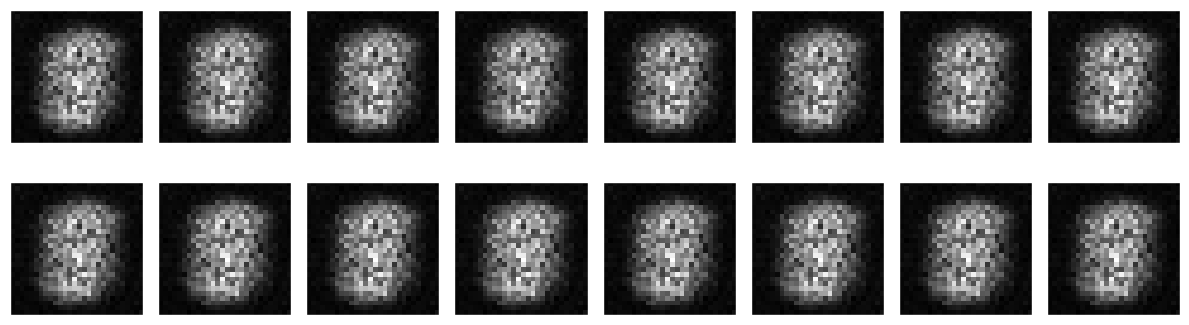

In [21]:
show_generated_images(epoch=1, n_cols=8)

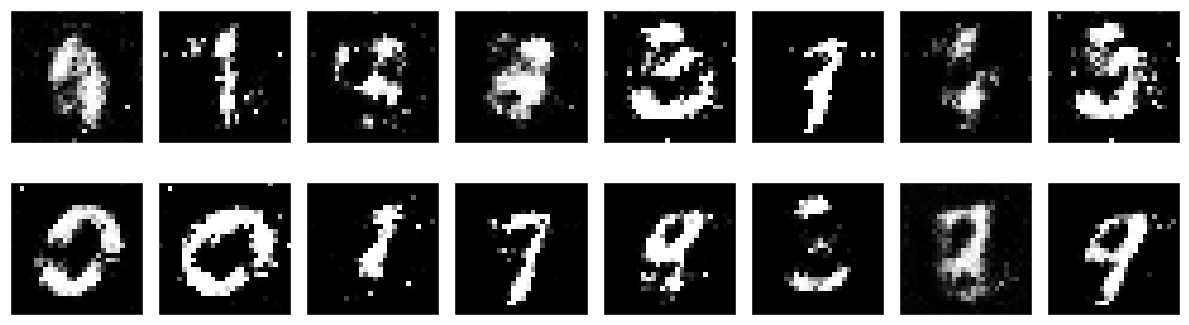

In [22]:
show_generated_images(epoch=10, n_cols=8)

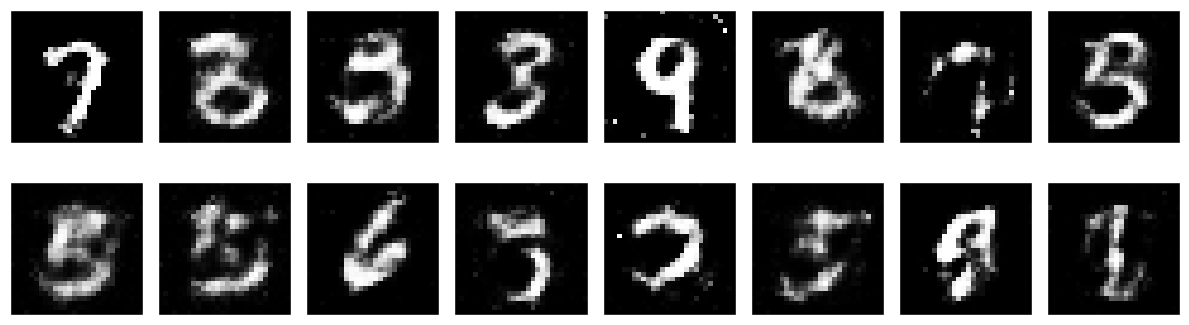

In [23]:
show_generated_images(epoch=50, n_cols=8)

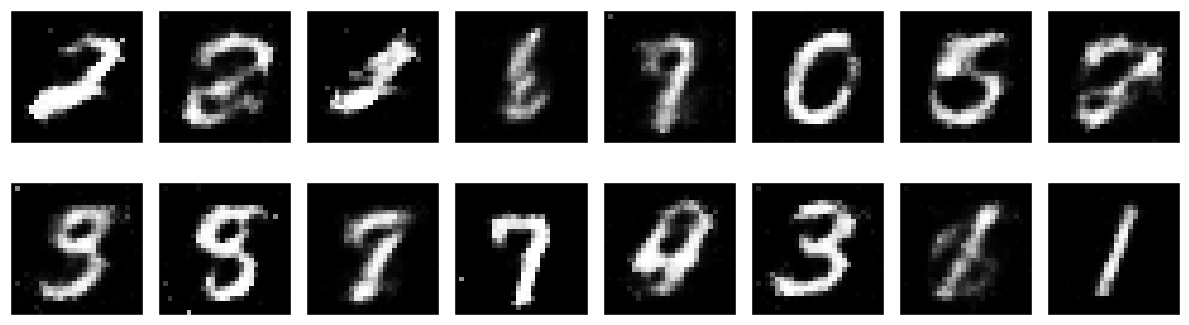

In [24]:
show_generated_images(epoch=100, n_cols=8)

## Test the network
The trained generator can be used to generate a fake random digit that'd look like as if it came from MNIST dataset.
Discriminator can be discarded now.

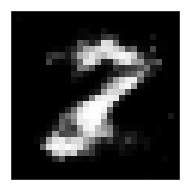

In [18]:
# Bring generator back to cpu and set eval mode on
g.to('cpu')
g.eval()
# Feed a latent vecor of size 100 to trained generator and get a fake generated image back
z = np.random.uniform(-1, 1, size=(1, 100))
z = torch.from_numpy(z).float()
fake_image = g(z)
# Reshape and display
fake_image = fake_image.view(1, 1, 28, 28).detach()
display_images(fake_image, n_cols=1, figsize=(2, 2))